In [1]:
import sqlite3
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import adjusted_rand_score
from sklearn.preprocessing import StandardScaler


from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.cluster import AgglomerativeClustering
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

## Connexion à la base SQLite

In [2]:
conn = sqlite3.connect("../Source/olist.db")

## Nous allons charger les tables pertinentes (customers, orders, order_items, order_reviews, order_pymts..)
## Fusionner les données pour avoir un client = une ligne

### Execution d'une requete dans une string et l'utiliser au travers d'une fonction pandas query sql

In [3]:
query = """
SELECT
    c.customer_unique_id,
    COUNT(DISTINCT o.order_id) AS nb_orders,
    MIN(o.order_purchase_timestamp) AS first_order_date,
    MAX(o.order_purchase_timestamp) AS last_order_date,
    ROUND(SUM(oi.price + oi.freight_value), 2) AS total_spent,
    AVG(r.review_score) AS avg_review_score,
    COUNT(DISTINCT op.payment_type) AS nb_payment_types
FROM customers c
JOIN orders o ON c.customer_id = o.customer_id
LEFT JOIN order_items oi ON o.order_id = oi.order_id
LEFT JOIN order_reviews r ON o.order_id = r.order_id
LEFT JOIN order_pymts op ON o.order_id = op.order_id
WHERE o.order_purchase_timestamp BETWEEN "{min_dt}" AND "{max_dt}"
GROUP BY c.customer_unique_id;
"""

In [4]:
print(query.format(min_dt='2016-09-04', max_dt='2018-10-17'))


SELECT
    c.customer_unique_id,
    COUNT(DISTINCT o.order_id) AS nb_orders,
    MIN(o.order_purchase_timestamp) AS first_order_date,
    MAX(o.order_purchase_timestamp) AS last_order_date,
    ROUND(SUM(oi.price + oi.freight_value), 2) AS total_spent,
    AVG(r.review_score) AS avg_review_score,
    COUNT(DISTINCT op.payment_type) AS nb_payment_types
FROM customers c
JOIN orders o ON c.customer_id = o.customer_id
LEFT JOIN order_items oi ON o.order_id = oi.order_id
LEFT JOIN order_reviews r ON o.order_id = r.order_id
LEFT JOIN order_pymts op ON o.order_id = op.order_id
WHERE o.order_purchase_timestamp BETWEEN "2016-09-04" AND "2018-10-17"
GROUP BY c.customer_unique_id;



In [5]:
df_clients = pd.read_sql_query(query.format(min_dt='2016-09-04', max_dt='2018-10-17'), conn)

In [6]:
df_clients

,customer_unique_id,nb_orders,first_order_date,last_order_date,total_spent,avg_review_score,nb_payment_types
0,0000366f3b9a7992bf8c76cfdf3221e2,1,2018-05-10 10:56:27,2018-05-10 10:56:27,141.90,5.0,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,2018-05-07 11:11:27,2018-05-07 11:11:27,27.19,4.0,1
2,0000f46a3911fa3c0805444483337064,1,2017-03-10 21:05:03,2017-03-10 21:05:03,86.22,3.0,1
3,0000f6ccb0745a6a4b88665a16c9f078,1,2017-10-12 20:29:41,2017-10-12 20:29:41,43.62,4.0,1
4,0004aac84e0df4da2b147fca70cf8255,1,2017-11-14 19:45:42,2017-11-14 19:45:42,196.89,5.0,1
...,...,...,...,...,...,...,...
96090,fffcf5a5ff07b0908bd4e2dbc735a684,1,2017-06-08 21:00:36,2017-06-08 21:00:36,2067.42,5.0,1
96091,fffea47cd6d3cc0a88bd621562a9d061,1,2017-12-10 20:07:56,2017-12-10 20:07:56,84.58,4.0,1
96092,ffff371b4d645b6ecea244b27531430a,1,2017-02-07 15:49:16,2017-02-07 15:49:16,112.46,5.0,1
96093,ffff5962728ec6157033ef9805bacc48,1,2018-05-02 15:17:41,2018-05-02 15:17:41,133.69,5.0,1


### Nous avons donc bien un client par ligne avec plusieurs indicateurs (variables/features) importants

## Nous allons maintenant enrichinir notre jeu de donnees avec d'avantage de feature

#### Ici on va stocker une date de reference, a savoir la date la plus recente

In [7]:
reference_date = df_clients['last_order_date'].max()

In [8]:
type(reference_date)

str

#### Nous convertissons notre date de reference au format datetime pour mieux la manipuler avec les autres colonnes

In [9]:
reference_date = datetime.strptime(reference_date, "%Y-%m-%d %H:%M:%S")
reference_date = pd.to_datetime(reference_date)

In [10]:
type(reference_date)
reference_date

Timestamp('2018-10-16 20:16:02')

In [11]:
df_clients['last_order_date'] = pd.to_datetime(df_clients['last_order_date'])
df_clients['first_order_date'] = pd.to_datetime(df_clients['first_order_date'])

In [12]:
df_clients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96095 entries, 0 to 96094
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   customer_unique_id  96095 non-null  object        
 1   nb_orders           96095 non-null  int64         
 2   first_order_date    96095 non-null  datetime64[ns]
 3   last_order_date     96095 non-null  datetime64[ns]
 4   total_spent         95420 non-null  float64       
 5   avg_review_score    95379 non-null  float64       
 6   nb_payment_types    96095 non-null  int64         
dtypes: datetime64[ns](2), float64(2), int64(2), object(1)
memory usage: 5.1+ MB


In [13]:
df_clients['recency'] = (reference_date - df_clients['last_order_date']).dt.days

### Nous venons donc de creer une nouvelle variable "recency" qui nous donne la recence des commandes pour nos clients. Un des parametre du RFM

In [14]:
df_clients

,customer_unique_id,nb_orders,first_order_date,last_order_date,total_spent,avg_review_score,nb_payment_types,recency
0,0000366f3b9a7992bf8c76cfdf3221e2,1,2018-05-10 10:56:27,2018-05-10 10:56:27,141.90,5.0,1,159
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,2018-05-07 11:11:27,2018-05-07 11:11:27,27.19,4.0,1,162
2,0000f46a3911fa3c0805444483337064,1,2017-03-10 21:05:03,2017-03-10 21:05:03,86.22,3.0,1,584
3,0000f6ccb0745a6a4b88665a16c9f078,1,2017-10-12 20:29:41,2017-10-12 20:29:41,43.62,4.0,1,368
4,0004aac84e0df4da2b147fca70cf8255,1,2017-11-14 19:45:42,2017-11-14 19:45:42,196.89,5.0,1,336
...,...,...,...,...,...,...,...,...
96090,fffcf5a5ff07b0908bd4e2dbc735a684,1,2017-06-08 21:00:36,2017-06-08 21:00:36,2067.42,5.0,1,494
96091,fffea47cd6d3cc0a88bd621562a9d061,1,2017-12-10 20:07:56,2017-12-10 20:07:56,84.58,4.0,1,310
96092,ffff371b4d645b6ecea244b27531430a,1,2017-02-07 15:49:16,2017-02-07 15:49:16,112.46,5.0,1,616
96093,ffff5962728ec6157033ef9805bacc48,1,2018-05-02 15:17:41,2018-05-02 15:17:41,133.69,5.0,1,167


### Nos deux autres parametre F (Frequence) et M (montant), nous les avons deja au travers des variables suivantes :  nb_orders et total_spent

### Par contre il serait interessant de savoir quel est le delais moyen entre chaque commande pour nos clients

In [15]:
df_clients['avg_days_between_orders'] = ((df_clients['last_order_date'] - df_clients['first_order_date']).dt.days / df_clients['nb_orders'].replace(1, np.nan))

In [16]:
df_clients['avg_days_between_orders'] = df_clients['avg_days_between_orders'].round(2)

In [17]:
df_clients

,customer_unique_id,nb_orders,first_order_date,last_order_date,total_spent,avg_review_score,nb_payment_types,recency,avg_days_between_orders
0,0000366f3b9a7992bf8c76cfdf3221e2,1,2018-05-10 10:56:27,2018-05-10 10:56:27,141.90,5.0,1,159,NaN
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,2018-05-07 11:11:27,2018-05-07 11:11:27,27.19,4.0,1,162,NaN
2,0000f46a3911fa3c0805444483337064,1,2017-03-10 21:05:03,2017-03-10 21:05:03,86.22,3.0,1,584,NaN
3,0000f6ccb0745a6a4b88665a16c9f078,1,2017-10-12 20:29:41,2017-10-12 20:29:41,43.62,4.0,1,368,NaN
4,0004aac84e0df4da2b147fca70cf8255,1,2017-11-14 19:45:42,2017-11-14 19:45:42,196.89,5.0,1,336,NaN
...,...,...,...,...,...,...,...,...,...
96090,fffcf5a5ff07b0908bd4e2dbc735a684,1,2017-06-08 21:00:36,2017-06-08 21:00:36,2067.42,5.0,1,494,NaN
96091,fffea47cd6d3cc0a88bd621562a9d061,1,2017-12-10 20:07:56,2017-12-10 20:07:56,84.58,4.0,1,310,NaN
96092,ffff371b4d645b6ecea244b27531430a,1,2017-02-07 15:49:16,2017-02-07 15:49:16,112.46,5.0,1,616,NaN
96093,ffff5962728ec6157033ef9805bacc48,1,2018-05-02 15:17:41,2018-05-02 15:17:41,133.69,5.0,1,167,NaN


In [18]:
(df_clients['last_order_date'] - df_clients['first_order_date']).value_counts()

0 days 00:00:00      93355
0 days 00:00:01        302
0 days 00:00:02         81
0 days 00:00:03         25
0 days 00:00:04         11
                     ...  
67 days 08:40:29         1
218 days 23:15:26        1
73 days 23:43:00         1
148 days 13:25:38        1
204 days 01:57:22        1
Name: count, Length: 2300, dtype: int64

### Il serait interessant de transformer la variable nb_payment_type, qui en l'etait n'a pas reellement de sens, surtout pour le Kmeans futur puisque un client avec 3 types de paiement est "plus éloigné" de celui avec 1 que de celui avec 2. 
### la distance entre 1 et 3 est deux fois plus grande qu'entre 1 et 2.
### Nous allons appliquer une colonne par type de paiment plutot

In [19]:
query_payment_type = """
SELECT 
    c.customer_unique_id,
    op.payment_type
FROM customers c
JOIN orders o ON c.customer_id = o.customer_id
JOIN order_pymts op ON o.order_id = op.order_id
"""

In [20]:
df_payments = pd.read_sql_query(query_payment_type, conn)
df_payments_dummies = pd.get_dummies(df_payments, columns=['payment_type'], prefix='payment')

# Regrouper par client
df_payment_types = df_payments_dummies.groupby('customer_unique_id').sum().reset_index()

In [21]:
# On merge les types de paiement avec le df_clients
# On remplace les NaN par 0
df_clients = df_clients.merge(df_payment_types, on='customer_unique_id', how='left')
df_clients.fillna(0, inplace=True)  # en cas de clients sans info paiement

### POur le moment nous avons des informations plutot interessantes. Nous pourrons en rajouter par la suite.
### Nous pouvons nous commencer a regarder de plus pres les differentes manieres de clustering

#### Commencons par quelques verifications

In [22]:
df_clients.isnull().sum()

customer_unique_id         0
nb_orders                  0
first_order_date           0
last_order_date            0
total_spent                0
avg_review_score           0
nb_payment_types           0
recency                    0
avg_days_between_orders    0
payment_boleto             0
payment_credit_card        0
payment_debit_card         0
payment_not_defined        0
payment_voucher            0
dtype: int64

#### Ok nous remarquons que sur plusieurs features nous avons des valeurs null, total_spent / avg_review_score / avg_days_between_orders . Pour avg_days nous allopns comblers les valeurs null, qui correspondent au mono-acheteur par une valeur generique -1 par exemple.

In [23]:
df_clients['avg_days_between_orders'].fillna(-1, inplace=True)

In [24]:
print(df_clients.shape)
print(df_clients.dtypes.value_counts())
print(df_clients.isnull().sum().sort_values(ascending=False))

(96095, 14)
float64           8
int64             3
datetime64[ns]    2
object            1
Name: count, dtype: int64
customer_unique_id         0
nb_orders                  0
first_order_date           0
last_order_date            0
total_spent                0
avg_review_score           0
nb_payment_types           0
recency                    0
avg_days_between_orders    0
payment_boleto             0
payment_credit_card        0
payment_debit_card         0
payment_not_defined        0
payment_voucher            0
dtype: int64


In [25]:
def filling_rate(dataframe):
    
    nb_rows, nb_columns = dataframe.shape

    nb_data = dataframe.count().sum()

    filling_rate = nb_data / (nb_rows * nb_columns)
    print("The global filling rate of the DataFrame is : {:.2%}".format(filling_rate))
      
    frequencies = [filling_rate, 1 - filling_rate]
    labels = ["Filled data", "Missing data"]
    
    fig, ax = plt.subplots(figsize=(5, 5))
    plt.title("Filling of the DataFrame", fontsize=25)
    ax.axis("equal")
    explode = (0.1, 0)

    ax.pie(frequencies,
           explode=explode,
           # labels=labels,
           autopct='%1.2f%%',
           shadow=True,
          )
    plt.legend(labels)

The global filling rate of the DataFrame is : 100.00%


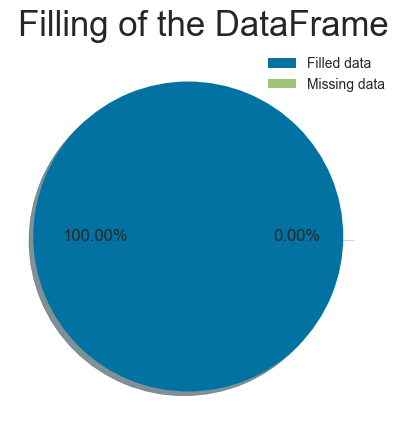

In [26]:
filling_rate(df_clients)

In [27]:
df_clients.describe(include='all')

,customer_unique_id,nb_orders,first_order_date,last_order_date,total_spent,avg_review_score,nb_payment_types,recency,avg_days_between_orders,payment_boleto,payment_credit_card,payment_debit_card,payment_not_defined,payment_voucher
count,96095,96095.000000,96095,96095,96095.000000,96095.000000,96095.000000,96095.000000,96095.000000,96095.000000,96095.000000,96095.000000,96095.000000,96095.000000
unique,96095,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,0000366f3b9a7992bf8c76cfdf3221e2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,1.034809,2017-12-30 19:14:48.856100608,2018-01-02 12:36:00.531057664,173.200804,4.054293,1.026661,286.902617,1.275949,0.205880,0.799157,0.015911,0.000031,0.060086
min,NaN,1.000000,2016-09-04 21:15:19,2016-09-04 21:15:19,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,NaN,1.000000,2017-09-11 19:51:26,2017-09-15 09:02:53.500000,63.270000,4.000000,1.000000,163.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
50%,NaN,1.000000,2018-01-18 13:29:55,2018-01-21 19:33:46,109.820000,5.000000,1.000000,268.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,NaN,1.000000,2018-05-04 10:36:15,2018-05-06 20:13:51,188.200000,5.000000,1.000000,396.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
max,NaN,17.000000,2018-09-29 09:13:03,2018-10-16 20:16:02,13664.080000,5.000000,3.000000,771.000000,304.000000,6.000000,17.000000,2.000000,1.000000,33.000000


In [28]:
df_clients.dropna(subset=['total_spent', 'avg_review_score'], inplace=True)

#### Nous allons selectionner nous features numeriques les plus pertinentes

#### 'nb_payment_types' atransformer en 3 colonnes pour chaque type

In [29]:
features = [
    'recency',
    'nb_orders',
    'total_spent',
    'avg_review_score',
    'avg_days_between_orders',
    'payment_boleto',
    'payment_credit_card',
    'payment_debit_card',
    'payment_voucher',
    'payment_not_defined'
]

X = df_clients[features]

#### Nous travaillons avec des valeurs de differentes echelles, nous allons donc devoir passer par une etape de normalisation

In [30]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [31]:
X["nb_orders"].value_counts()

nb_orders
1     93098
2      2745
3       203
4        30
5         8
6         6
7         3
9         1
17        1
Name: count, dtype: int64

In [32]:
pd.DataFrame(X_scaled, columns=features)["nb_orders"].value_counts()

nb_orders
-0.162369     93098
 4.502164      2745
 9.166697       203
 13.831230       30
 18.495764        8
 23.160297        6
 27.824830        3
 37.153896        1
 74.470162        1
Name: count, dtype: int64

#### Notre scaler a bien conserve l'importance des valeurs importantes. Ce qui est primordiale pour ne pas perdre l'importance/impact de nos plus gros clients

## Maintenant nous allons devoir trouver le bon nombre de K cluster. Pour ca nous allons passer par la methode du coude

c:\Users\cosic\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\cosic\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\cosic\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\cosic\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\clus

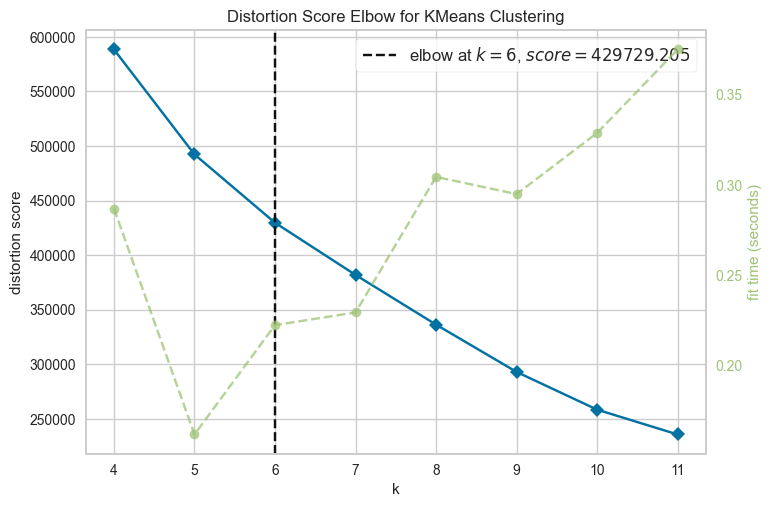

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [33]:
model = KMeans()
ke_visualizer = KElbowVisualizer(model, k=(4,12))

ke_visualizer.fit(X_scaled)
ke_visualizer.poof()

c:\Users\cosic\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


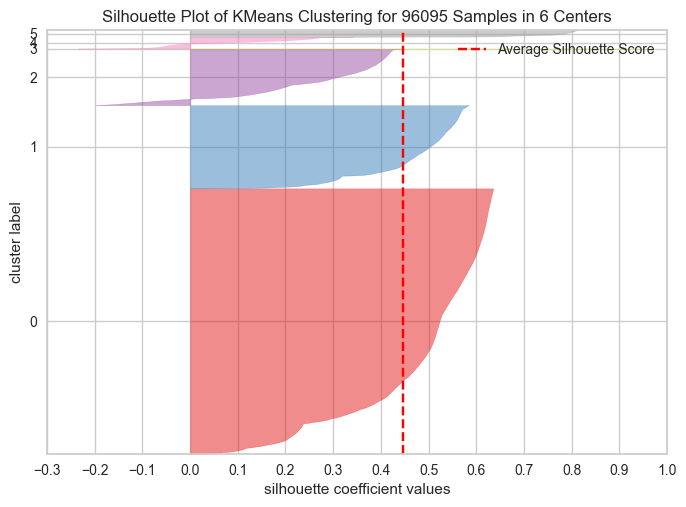

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 96095 Samples in 6 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [34]:
model_2 = KMeans(6)
s_visualizer = SilhouetteVisualizer(model_2)

s_visualizer.fit(X_scaled)
s_visualizer.poof()

#### Ce score de silouhette est calcule en faisant la moyenne du coefficient de silhouette pour chaque échantillon, qui correspond à la différence entre la distance moyenne intra-grappe et la distance moyenne entre les grappes les plus proches pour chaque échantillon, normalisée par la valeur maximale.
#### On retrouve donc un score entre -1 et 1 où les scores proches de 1 indiquent une forte séparation et les scores proches de -1 indiquent que les échantillons peuvent avoir été assignés au mauvais groupe.

#### Nous obtenons donc un K = 6

In [35]:
# Nous pouvons recuperer le nombre de clusters optimal de cette facon egalemnent
opt_k = 6
print("Le nombre optimal de clusters est : ", opt_k)

Le nombre optimal de clusters est :  6


In [36]:
optimal_k = opt_k
final_model = KMeans(n_clusters=optimal_k, random_state=42)
df_clients['cluster'] = final_model.fit_predict(X_scaled)

c:\Users\cosic\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [37]:
df_clients['cluster'].value_counts()

cluster
1    56644
0    18979
3    17584
4     1501
2     1384
5        3
Name: count, dtype: int64

#### Nous allons mener quelques analyses sur ces clusters

In [38]:
df_clusters = df_clients.groupby('cluster')[features].mean()
df_clusters

,recency,nb_orders,total_spent,avg_review_score,avg_days_between_orders,payment_boleto,payment_credit_card,payment_debit_card,payment_voucher,payment_not_defined
cluster,,,,,,,,,,
0,297.474261,1.020654,146.170108,4.055040,0.159395,1.016755,0.003214,0.000000,0.000685,0.0
1,284.622378,1.015024,170.070045,4.747572,0.057093,0.000035,0.999859,0.000000,0.065673,0.0
2,220.772399,2.241329,396.825694,4.217162,82.401640,0.330925,1.836705,0.008671,0.299855,0.0
3,294.154288,1.018767,197.239649,1.800042,0.068045,0.000626,0.997100,0.000000,0.092357,0.0
4,215.785476,1.035310,145.631872,4.145086,0.737062,0.009993,0.015323,1.010660,0.001332,0.0
5,47.000000,1.333333,19.663333,1.666667,2.166667,0.333333,0.000000,0.000000,0.000000,1.0


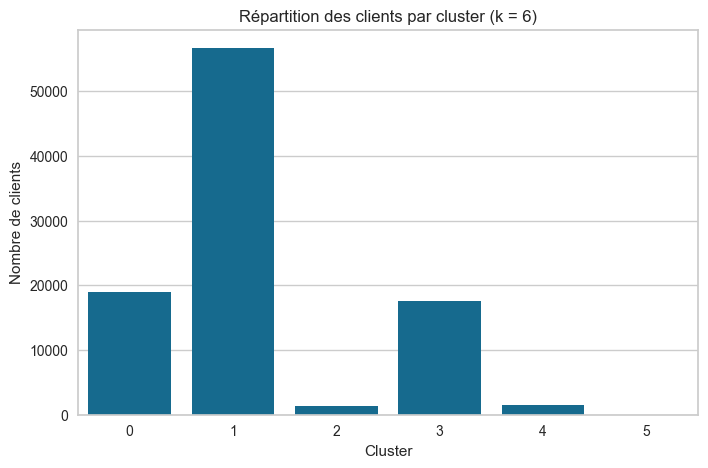

In [39]:
plt.figure(figsize=(8, 5))
sns.countplot(data=df_clients, x='cluster')
plt.xlabel("Cluster")
plt.ylabel("Nombre de clients")
plt.title("Répartition des clients par cluster (k = 6)")
plt.show()

### Ici on remarque que nos 3 clusters principaux sont le 0, 3 et 5. Les autres clusters sont beaucoup plus ecrases quand on regarde la silouhette et la repartition. Les clusters plus petits meritent d'etre plus detailles ou d'etre fusionnes.

### Nous pouvons reduire le nombre de cluster, prenons k=6

In [40]:
df_clients

,customer_unique_id,nb_orders,first_order_date,last_order_date,total_spent,avg_review_score,nb_payment_types,recency,avg_days_between_orders,payment_boleto,payment_credit_card,payment_debit_card,payment_not_defined,payment_voucher,cluster
0,0000366f3b9a7992bf8c76cfdf3221e2,1,2018-05-10 10:56:27,2018-05-10 10:56:27,141.90,5.0,1,159,0.0,0.0,1.0,0.0,0.0,0.0,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,2018-05-07 11:11:27,2018-05-07 11:11:27,27.19,4.0,1,162,0.0,0.0,1.0,0.0,0.0,0.0,1
2,0000f46a3911fa3c0805444483337064,1,2017-03-10 21:05:03,2017-03-10 21:05:03,86.22,3.0,1,584,0.0,0.0,1.0,0.0,0.0,0.0,3
3,0000f6ccb0745a6a4b88665a16c9f078,1,2017-10-12 20:29:41,2017-10-12 20:29:41,43.62,4.0,1,368,0.0,0.0,1.0,0.0,0.0,0.0,1
4,0004aac84e0df4da2b147fca70cf8255,1,2017-11-14 19:45:42,2017-11-14 19:45:42,196.89,5.0,1,336,0.0,0.0,1.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96090,fffcf5a5ff07b0908bd4e2dbc735a684,1,2017-06-08 21:00:36,2017-06-08 21:00:36,2067.42,5.0,1,494,0.0,0.0,1.0,0.0,0.0,0.0,1
96091,fffea47cd6d3cc0a88bd621562a9d061,1,2017-12-10 20:07:56,2017-12-10 20:07:56,84.58,4.0,1,310,0.0,0.0,1.0,0.0,0.0,0.0,1
96092,ffff371b4d645b6ecea244b27531430a,1,2017-02-07 15:49:16,2017-02-07 15:49:16,112.46,5.0,1,616,0.0,0.0,1.0,0.0,0.0,0.0,1
96093,ffff5962728ec6157033ef9805bacc48,1,2018-05-02 15:17:41,2018-05-02 15:17:41,133.69,5.0,1,167,0.0,0.0,1.0,0.0,0.0,0.0,1


## Nous allons tester un autre modele de clustering, DBSCAN

In [41]:
dbscan = DBSCAN(eps=0.5, min_samples=10)

In [42]:
df_clients['cluster_dbscan'] = dbscan.fit_predict(X_scaled)

In [43]:
df_clients['cluster_dbscan'].value_counts()

cluster_dbscan
 0     68245
 2     10461
 1      5140
-1      3503
 4      2039
 7       938
 9       850
 16      774
 10      556
 6       555
 15      491
 11      290
 13      261
 22      171
 3       155
 21      155
 29      138
 5       127
 24      127
 18      109
 19      105
 28      103
 20       90
 23       80
 25       71
 12       63
 27       48
 37       38
 35       32
 8        32
 31       30
 26       28
 32       27
 42       27
 36       22
 30       21
 14       18
 17       17
 39       16
 38       16
 44       15
 43       14
 34       13
 45       12
 33       12
 41       11
 49       11
 46       10
 47       10
 40       10
 48        8
Name: count, dtype: int64

#### Ici on voit que le DBSCAN ressence enormement de clusters .. environ une cinquantaine. On capte 1 gros cluster le 0 de lpus de 68k clients puis le 2 avec 10k clients et le 1 avec 5k. On note egalement plus de 3k outliers defini par -1. Les autres clusters sont beaucoup plus petit et sont comme marginaux compares aux 3 1ers

#### Si nous voudrions diminuer la quantite de cluster nous pourrions jouer sur le parametre eps et le diminuer

### Visualisons nos cluster du Kmeans

In [44]:
df_clients.groupby('cluster')[features].mean().round(2)

,recency,nb_orders,total_spent,avg_review_score,avg_days_between_orders,payment_boleto,payment_credit_card,payment_debit_card,payment_voucher,payment_not_defined
cluster,,,,,,,,,,
0,297.47,1.02,146.17,4.06,0.16,1.02,0.00,0.00,0.00,0.0
1,284.62,1.02,170.07,4.75,0.06,0.00,1.00,0.00,0.07,0.0
2,220.77,2.24,396.83,4.22,82.40,0.33,1.84,0.01,0.30,0.0
3,294.15,1.02,197.24,1.80,0.07,0.00,1.00,0.00,0.09,0.0
4,215.79,1.04,145.63,4.15,0.74,0.01,0.02,1.01,0.00,0.0
5,47.00,1.33,19.66,1.67,2.17,0.33,0.00,0.00,0.00,1.0


In [45]:
df_clients['cluster'].value_counts(normalize=True).sort_index()

cluster
0    0.197502
1    0.589458
2    0.014402
3    0.182986
4    0.015620
5    0.000031
Name: proportion, dtype: float64

 Cluster 0 — Clients fidèles mais inactifs
Poids : 58 % des clients

Récence moyenne : 285 jours

Nombre de commandes : 1

Dépenses moyennes : 169 R$

Score de review : 4.75 ⭐

Moyens de paiement : principalement carte de crédit, un peu de voucher

Cluster 1 — Clients récents avec paiement par carte de débit
Poids : 1,5 %

Récence : 216 jours

Commandes : 1

Dépenses : 146 R$

Review : 4.15

Paiement : exclusivement débit

Cluster 2 — Clients très mécontents
Poids : 17,9 %

Récence : 295 jours

Commandes : 1

Dépenses : 188 R$

Review : 1.79 ⭐

Paiement : surtout carte de crédit + voucher

 Cluster 3 — Acheteurs simples avec boleto
Poids : 19,7 %

Récence : 298 jours

Commandes : 1

Dépenses : 145 R$

Review : 4.05

Paiement : exclusivement boleto (paiement différé brésilien)

Cluster 4 — Clients fidèles et à forte valeur
Poids : 2,76 %

Récence : 265 jours

Commandes : 2+

Dépenses moyennes : 385 R$

Review : 4.10

Paiements : diversifiés (carte + boleto + voucher)

Cluster 5 — Clients récents mécontents
Poids : 0,003 % (extrêmement rare)

Récence : 47 jours

Commandes : 1

Dépenses : 19 R$

Review : 1.67

Paiement : non défini

## Bilan sur nos clients : 
Cluster 0 + 3 = 77 % ➝ gros volume, potentiel de réactivation

Cluster 2 = 18 % ➝ éviter ou traiter

Cluster 4 = à prioriser

Cluster 1 + 5 = niches → à monitorer mais pas centrales

In [46]:
df_clients

,customer_unique_id,nb_orders,first_order_date,last_order_date,total_spent,avg_review_score,nb_payment_types,recency,avg_days_between_orders,payment_boleto,payment_credit_card,payment_debit_card,payment_not_defined,payment_voucher,cluster,cluster_dbscan
0,0000366f3b9a7992bf8c76cfdf3221e2,1,2018-05-10 10:56:27,2018-05-10 10:56:27,141.90,5.0,1,159,0.0,0.0,1.0,0.0,0.0,0.0,1,0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,2018-05-07 11:11:27,2018-05-07 11:11:27,27.19,4.0,1,162,0.0,0.0,1.0,0.0,0.0,0.0,1,0
2,0000f46a3911fa3c0805444483337064,1,2017-03-10 21:05:03,2017-03-10 21:05:03,86.22,3.0,1,584,0.0,0.0,1.0,0.0,0.0,0.0,3,0
3,0000f6ccb0745a6a4b88665a16c9f078,1,2017-10-12 20:29:41,2017-10-12 20:29:41,43.62,4.0,1,368,0.0,0.0,1.0,0.0,0.0,0.0,1,0
4,0004aac84e0df4da2b147fca70cf8255,1,2017-11-14 19:45:42,2017-11-14 19:45:42,196.89,5.0,1,336,0.0,0.0,1.0,0.0,0.0,0.0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96090,fffcf5a5ff07b0908bd4e2dbc735a684,1,2017-06-08 21:00:36,2017-06-08 21:00:36,2067.42,5.0,1,494,0.0,0.0,1.0,0.0,0.0,0.0,1,-1
96091,fffea47cd6d3cc0a88bd621562a9d061,1,2017-12-10 20:07:56,2017-12-10 20:07:56,84.58,4.0,1,310,0.0,0.0,1.0,0.0,0.0,0.0,1,0
96092,ffff371b4d645b6ecea244b27531430a,1,2017-02-07 15:49:16,2017-02-07 15:49:16,112.46,5.0,1,616,0.0,0.0,1.0,0.0,0.0,0.0,1,0
96093,ffff5962728ec6157033ef9805bacc48,1,2018-05-02 15:17:41,2018-05-02 15:17:41,133.69,5.0,1,167,0.0,0.0,1.0,0.0,0.0,0.0,1,0


### Afin de calculer l'ARI, je vais devoir definir deux segmentations pour les modeles sur des dates differentes

In [47]:
# Recuperer la date la plus recente et la plus ancienne
df_clients['first_order_date'].min(), df_clients['last_order_date'].max()

(Timestamp('2016-09-04 21:15:19'), Timestamp('2018-10-16 20:16:02'))

#### On va prendre deux periodes avec un differentiel d'un mois, septembre 2017 a septembre 2018 / octobre 2017 a octobre 2018

In [48]:
# Dates
t0_start = pd.to_datetime("2017-09-01")
t0_end   = pd.to_datetime("2018-09-30")

t1_start = pd.to_datetime("2017-10-01")
t1_end   = pd.to_datetime("2018-10-31")

# Jeux d'entraînement
df_t0 = df_clients[
    (df_clients['last_order_date'] >= t0_start) &
    (df_clients['last_order_date'] <= t0_end)
].copy()

df_t1 = df_clients[
    (df_clients['last_order_date'] >= t1_start) &
    (df_clients['last_order_date'] <= t1_end)
].copy()

In [49]:
print("Clients T1 :", df_t0.shape)
print("Clients T2 :", df_t1.shape)

Clients T1 : (74032, 16)
Clients T2 : (69961, 16)


In [50]:
scaler = StandardScaler().fit(df_t0[features])

In [51]:
X_t0 = scaler.transform(df_t0[features])
X_t1 = scaler.transform(df_t1[features])

In [52]:
model_m0 = KMeans(n_clusters=6, random_state=42).fit(X_t0)
model_m1 = KMeans(n_clusters=6, random_state=42).fit(X_t1)

c:\Users\cosic\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\cosic\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [53]:
df_t1['cluster_m0'] = model_m0.predict(X_t1)
df_t1['cluster_m1'] = model_m1.predict(X_t1)

### Calcul de  l'ARI

In [54]:
ari = adjusted_rand_score(df_t1['cluster_m0'], df_t1['cluster_m1'])
print(f"🎯 Adjusted Rand Index (M0 vs M1 sur T1) : {ari:.3f}")

🎯 Adjusted Rand Index (M0 vs M1 sur T1) : 0.955


#### Au vu du resultat ARI, on peut en deduire que le modèle M0 (entraîné sur T0) et le modèle M1 (entraîné sur T1) produisent des clusters quasi identiques sur les mêmes clients (période T1).
#### Cela signifie que notre segmentation est stable d’un mois à l’autre, malgré le décalage dans les données d'entraînement.

## Nous avons teste la stabilite de notre modele avec 1 mois de decalage, je vais reiterer l'operation en soumettant en decalage plus important (2 mois) pour voir comment se comporte l'ARI

In [55]:
# Decalage de 2 mois

t0_start = pd.to_datetime("2017-09-01")
t0_end   = pd.to_datetime("2018-09-30")

t1_start = pd.to_datetime("2017-11-01")
t1_end   = pd.to_datetime("2018-11-30")

# Jeux d'entraînement
df_t0 = df_clients[
    (df_clients['last_order_date'] >= t0_start) &
    (df_clients['last_order_date'] <= t0_end)
].copy()

df_t1 = df_clients[
    (df_clients['last_order_date'] >= t1_start) &
    (df_clients['last_order_date'] <= t1_end)
].copy()

print("Clients T1 :", df_t0.shape)
print("Clients T2 :", df_t1.shape)

scaler = StandardScaler().fit(df_t0[features])

X_t0 = scaler.transform(df_t0[features])
X_t1 = scaler.transform(df_t1[features])

model_m0 = KMeans(n_clusters=6, random_state=42).fit(X_t0)
model_m1 = KMeans(n_clusters=6, random_state=42).fit(X_t1)

df_t1['cluster_m0'] = model_m0.predict(X_t1)
df_t1['cluster_m1'] = model_m1.predict(X_t1)

ari = adjusted_rand_score(df_t1['cluster_m0'], df_t1['cluster_m1'])
print(f"🎯 Adjusted Rand Index (M0 vs M1 sur T1) : {ari:.3f}")

Clients T1 : (74032, 16)
Clients T2 : (65521, 16)


c:\Users\cosic\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\cosic\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


🎯 Adjusted Rand Index (M0 vs M1 sur T1) : 0.574


### Afin d'etre plus rigoureux je vais creer une boucle qui va tester different modele avec un delta de decalage 

## T0 : période d’entraînement du modèle
## T1 : période de test
## Δ = décalage entre T0 et T1

In [56]:
date_max = pd.to_datetime("2018-10-17")
features = ['recency', 'nb_orders', 'total_spent', 'avg_review_score',
            'avg_days_between_orders', 'payment_boleto', 'payment_credit_card',
            'payment_debit_card', 'payment_voucher', 'payment_not_defined']

In [57]:
delays = list(range(14, 90+1, 14))  # Délais de 2 semaines à 3 mois (en jours)
ari_scores = []

In [58]:
for delta in delays:
    # T1 : période de test (les 30 derniers jours)
    t1_end = date_max
    t1_start = t1_end - pd.Timedelta(days=60)
    
    # T0 : même durée que T1 mais avec un décalage de `delta` jours
    t0_end = t1_end - pd.Timedelta(days=delta)
    t0_start = t0_end - pd.Timedelta(days=365)

    df_t0 = df_clients[(df_clients['last_order_date'] >= t0_start) & (df_clients['last_order_date'] <= t0_end)].copy()
    df_t1 = df_clients[(df_clients['last_order_date'] >= t1_start) & (df_clients['last_order_date'] <= t1_end)].copy()
    
    # Filtrer si trop peu de clients
    if len(df_t0) < 500 or len(df_t1) < 300:
        continue

    # Scaling
    scaler = StandardScaler().fit(df_t0[features])
    X_t0 = scaler.transform(df_t0[features])
    X_t1 = scaler.transform(df_t1[features])

    # Entraînement modèles
    model_t0 = KMeans(n_clusters=6, random_state=42).fit(X_t0)
    model_t1 = KMeans(n_clusters=6, random_state=42).fit(X_t1)

    # Prédictions sur T1
    pred_m0 = model_t0.predict(X_t1)
    pred_m1 = model_t1.predict(X_t1)

    # ARI
    ari = adjusted_rand_score(pred_m0, pred_m1)
    ari_scores.append((delta, ari))

c:\Users\cosic\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\cosic\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\cosic\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\cosic\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\clus

In [59]:
ari_scores

[(14, 0.9956218557483456),
 (28, 0.6808757844270161),
 (42, 0.7760933218085019),
 (56, 0.6676322925116651),
 (70, 0.6516693689529326),
 (84, 0.6692178339061507)]

### Visualisation

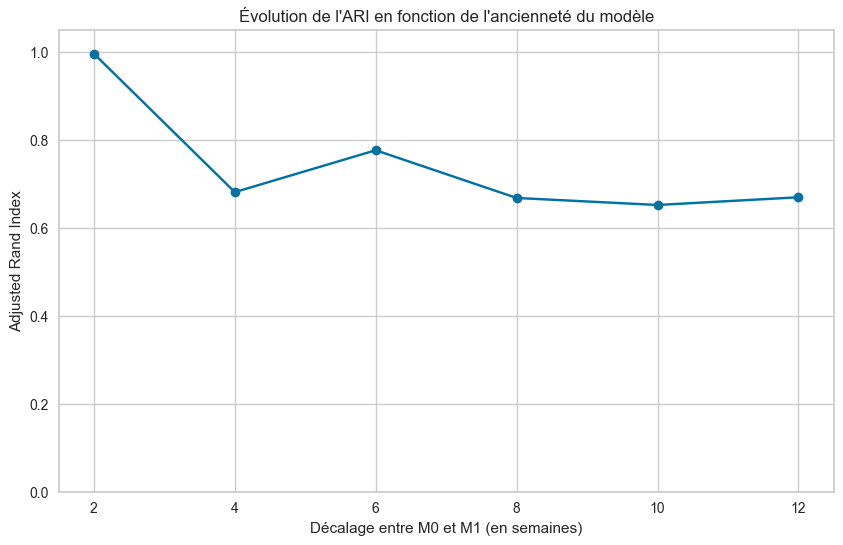

In [60]:
x_vals = [d // 7 for d, _ in ari_scores]
y_vals = [a for _, a in ari_scores]

plt.figure(figsize=(10, 6))
plt.plot(x_vals, y_vals, marker='o')
plt.title("Évolution de l'ARI en fonction de l'ancienneté du modèle")
plt.xlabel("Décalage entre M0 et M1 (en semaines)")
plt.ylabel("Adjusted Rand Index")
plt.grid(True)
plt.ylim(0, 1.05)
plt.show()

## T0 = 12 mois glissants,
## T1 = T0 + décalage Δ,
### puis comparaison de M0 vs M1 sur T1

In [61]:
df_t0

,customer_unique_id,nb_orders,first_order_date,last_order_date,total_spent,avg_review_score,nb_payment_types,recency,avg_days_between_orders,payment_boleto,payment_credit_card,payment_debit_card,payment_not_defined,payment_voucher,cluster,cluster_dbscan
0,0000366f3b9a7992bf8c76cfdf3221e2,1,2018-05-10 10:56:27,2018-05-10 10:56:27,141.90,5.0,1,159,0.0,0.0,1.0,0.0,0.0,0.0,1,0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,2018-05-07 11:11:27,2018-05-07 11:11:27,27.19,4.0,1,162,0.0,0.0,1.0,0.0,0.0,0.0,1,0
3,0000f6ccb0745a6a4b88665a16c9f078,1,2017-10-12 20:29:41,2017-10-12 20:29:41,43.62,4.0,1,368,0.0,0.0,1.0,0.0,0.0,0.0,1,0
4,0004aac84e0df4da2b147fca70cf8255,1,2017-11-14 19:45:42,2017-11-14 19:45:42,196.89,5.0,1,336,0.0,0.0,1.0,0.0,0.0,0.0,1,0
5,0004bd2a26a76fe21f786e4fbd80607f,1,2018-04-05 19:33:16,2018-04-05 19:33:16,166.98,4.0,1,194,0.0,0.0,1.0,0.0,0.0,0.0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96087,fffb09418989a0dbff854a28163e47c6,1,2017-12-17 19:14:35,2017-12-17 19:14:35,73.16,5.0,1,303,0.0,1.0,0.0,0.0,0.0,0.0,0,2
96088,fffbf87b7a1a6fa8b03f081c5f51a201,1,2017-12-27 22:36:41,2017-12-27 22:36:41,167.32,5.0,1,292,0.0,0.0,1.0,0.0,0.0,0.0,1,0
96089,fffcc512b7dfecaffd80f13614af1d16,1,2018-04-11 00:34:32,2018-04-11 00:34:32,710.70,1.0,1,188,0.0,0.0,1.0,0.0,0.0,0.0,3,0
96091,fffea47cd6d3cc0a88bd621562a9d061,1,2017-12-10 20:07:56,2017-12-10 20:07:56,84.58,4.0,1,310,0.0,0.0,1.0,0.0,0.0,0.0,1,0


In [62]:
features = ['recency', 'nb_orders', 'total_spent', 'avg_review_score',
            'avg_days_between_orders', 'payment_boleto', 'payment_credit_card',
            'payment_debit_card', 'payment_voucher', 'payment_not_defined']

delays = list(range(14, 90+1, 14))  # Délais de 2 semaines à 3 mois
ari_scores_year = []

for delta in delays:
    # Fenêtre T0 (12 mois terminant à date_max - delta)
    t0_end = date_max - pd.Timedelta(days=delta)
    t0_start = t0_end - pd.Timedelta(days=365)

    # Fenêtre T1 (12 mois terminant à date_max)
    t1_end = date_max
    t1_start = t1_end - pd.Timedelta(days=365)

    df_t0 = pd.read_sql_query(query.format(min_dt=t0_start, max_dt=t0_end), conn)
    df_t1 = pd.read_sql_query(query.format(min_dt=t1_start, max_dt=t1_end), conn)

    print(f"Δ = {delta} jours — T0 : {len(df_t0)} clients, T1 : {len(df_t1)} clients")

    if len(df_t0) < 500 or len(df_t1) < 500:
        continue

    # Scaling sur T0 uniquement
    scaler = StandardScaler().fit(df_t0[features])
    X_t0 = scaler.transform(df_t0[features])
    X_t1 = scaler.transform(df_t1[features])

    # Entraînement des deux modèles
    model_t0 = KMeans(n_clusters=6, random_state=42).fit(X_t0)
    model_t1 = KMeans(n_clusters=6, random_state=42).fit(X_t1)

    # Prédictions des deux modèles sur T1
    pred_m0 = model_t0.predict(X_t1)
    pred_m1 = model_t1.predict(X_t1)

    # Calcul ARI
    ari = adjusted_rand_score(pred_m0, pred_m1)
    ari_scores_year.append((delta, ari))

Δ = 14 jours — T0 : 69696 clients, T1 : 67658 clients


KeyError: "['recency', 'avg_days_between_orders', 'payment_boleto', 'payment_credit_card', 'payment_debit_card', 'payment_voucher', 'payment_not_defined'] not in index"

In [ ]:
ari_scores_year

[(14, 0.9569651927096828),
 (28, 0.9301466576647147),
 (42, 0.9246245746286258),
 (56, 0.9980640419071147),
 (70, 0.9489305770868494),
 (84, 0.9727123212375971)]

### Visualisation

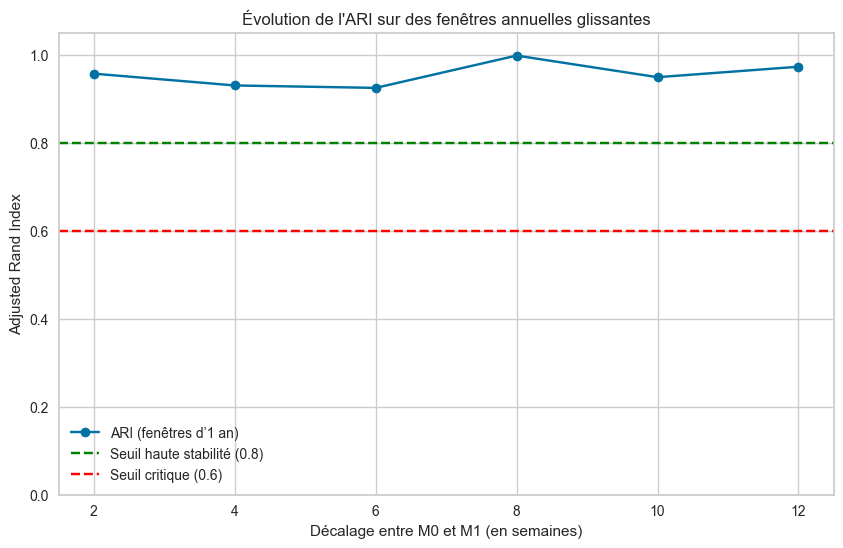

In [ ]:
x_vals = [d // 7 for d, _ in ari_scores_year]
y_vals = [a for _, a in ari_scores_year]

plt.figure(figsize=(10, 6))
plt.plot(x_vals, y_vals, marker='o', label="ARI (fenêtres d’1 an)")
plt.axhline(0.8, color='green', linestyle='--', label='Seuil haute stabilité (0.8)')
plt.axhline(0.6, color='red', linestyle='--', label='Seuil critique (0.6)')
plt.title("Évolution de l'ARI sur des fenêtres annuelles glissantes")
plt.xlabel("Décalage entre M0 et M1 (en semaines)")
plt.ylabel("Adjusted Rand Index")
plt.grid(True)
plt.legend()
plt.ylim(0, 1.05)
plt.show()

## Nous pouvons apporter certains visuel afin de mieux comprendre les clusters

C:\Users\cosic\AppData\Local\Temp\ipykernel_22420\3258238020.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_clients, x='cluster', y='total_spent', palette='Set2')


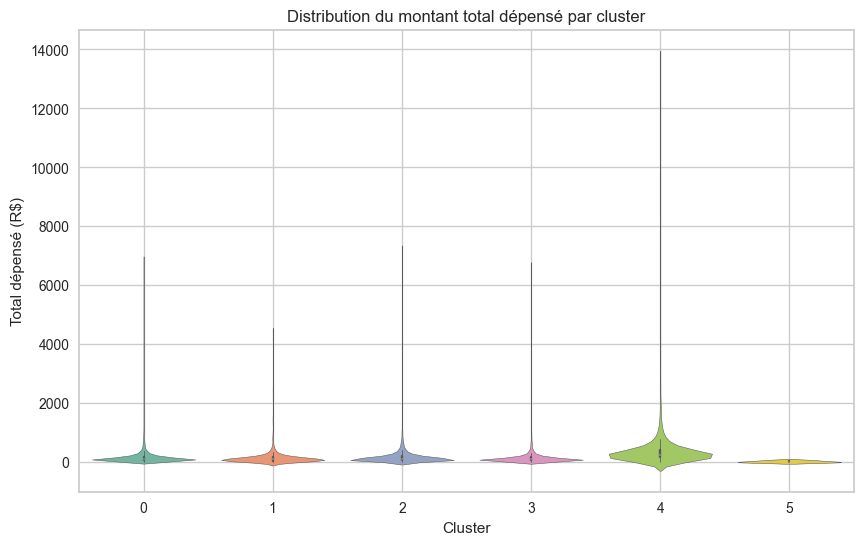

In [ ]:
plt.figure(figsize=(10, 6))
sns.violinplot(data=df_clients, x='cluster', y='total_spent', palette='Set2')
plt.title("Distribution du montant total dépensé par cluster")
plt.xlabel("Cluster")
plt.ylabel("Total dépensé (R$)")
plt.grid(True)
plt.show()

C:\Users\cosic\AppData\Local\Temp\ipykernel_22420\3665218031.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_clients, x='cluster', y=col, palette='Set2')


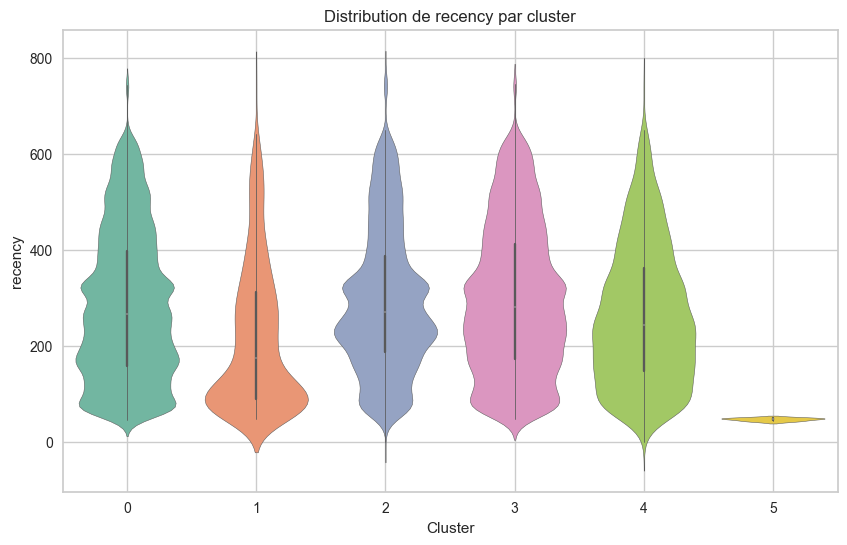

C:\Users\cosic\AppData\Local\Temp\ipykernel_22420\3665218031.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_clients, x='cluster', y=col, palette='Set2')


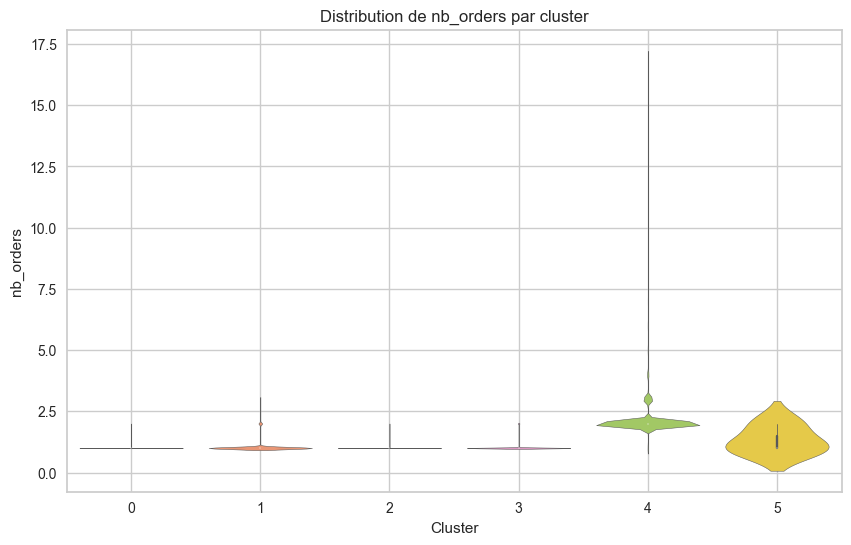

C:\Users\cosic\AppData\Local\Temp\ipykernel_22420\3665218031.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_clients, x='cluster', y=col, palette='Set2')


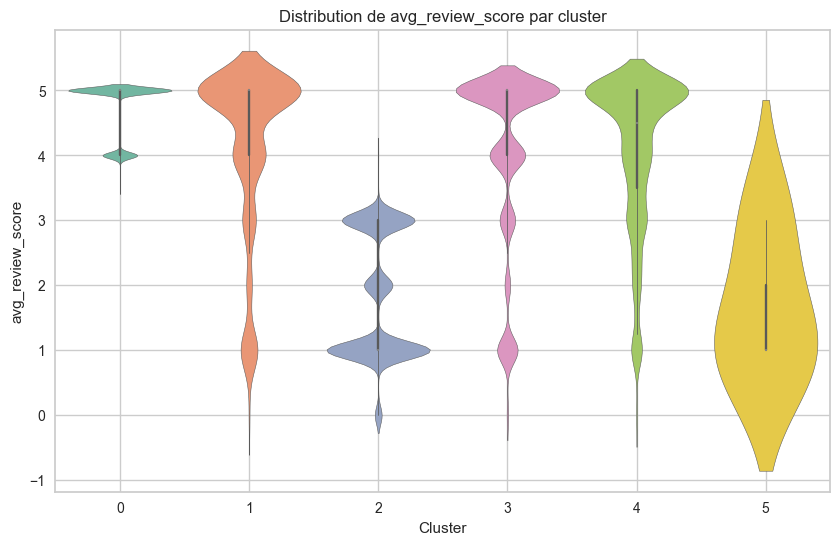

C:\Users\cosic\AppData\Local\Temp\ipykernel_22420\3665218031.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_clients, x='cluster', y=col, palette='Set2')


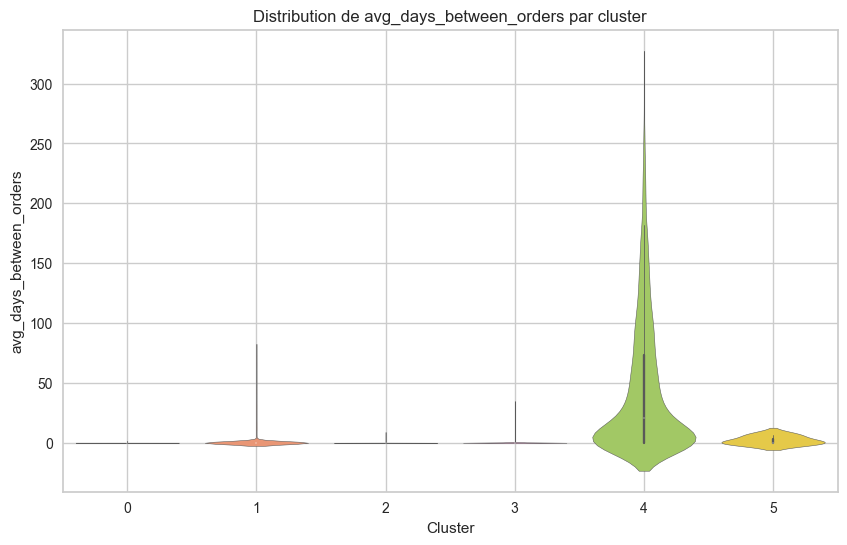

In [ ]:
for col in ['recency', 'nb_orders', 'avg_review_score', 'avg_days_between_orders']:
    plt.figure(figsize=(10, 6))
    sns.violinplot(data=df_clients, x='cluster', y=col, palette='Set2')
    plt.title(f"Distribution de {col} par cluster")
    plt.xlabel("Cluster")
    plt.ylabel(col)
    plt.grid(True)
    plt.show()

### Dispersion des clusters

C:\Users\cosic\AppData\Local\Temp\ipykernel_22420\2063916395.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_clients, x='cluster', palette='Set2')


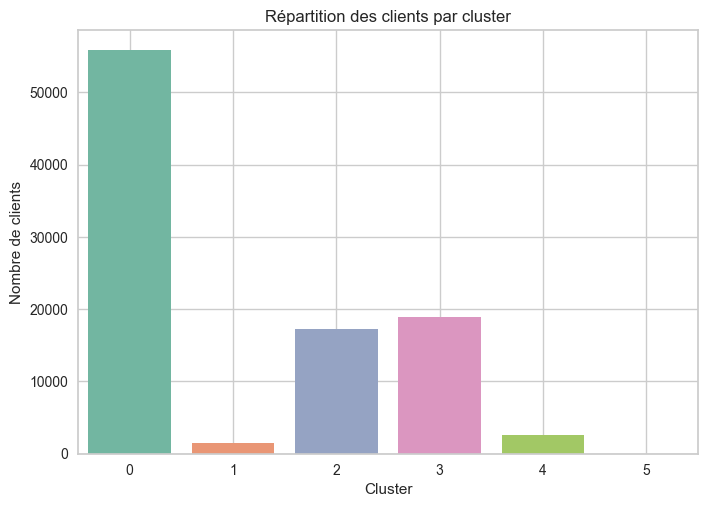

In [ ]:
sns.countplot(data=df_clients, x='cluster', palette='Set2')
plt.title("Répartition des clients par cluster")
plt.xlabel("Cluster")
plt.ylabel("Nombre de clients")
plt.grid(True)
plt.show()